AEP_MW    0
dtype: int64


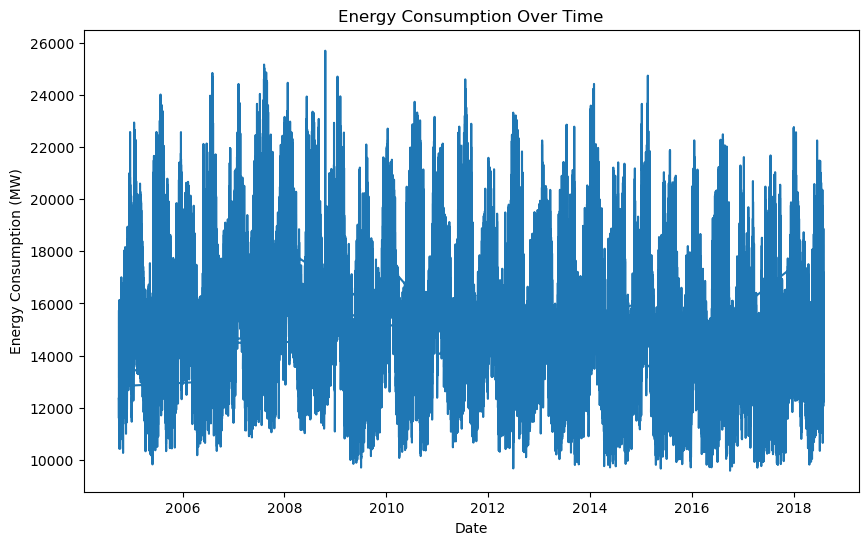

Epoch 1/10
3032/3032 [==============================] - 133s 40ms/step - loss: 0.0019
Epoch 2/10
3032/3032 [==============================] - 130s 43ms/step - loss: 5.6331e-04
Epoch 4/10
3032/3032 [==============================] - 183s 60ms/step - loss: 5.1347e-04
Epoch 5/10
3032/3032 [==============================] - 174s 57ms/step - loss: 4.8834e-04
Epoch 6/10
3032/3032 [==============================] - 175s 58ms/step - loss: 4.6390e-04
Epoch 7/10
3032/3032 [==============================] - 154s 51ms/step - loss: 4.3723e-04
Epoch 8/10
3032/3032 [==============================] - 138s 45ms/step - loss: 4.1853e-04
Epoch 9/10
3032/3032 [==============================] - 141s 47ms/step - loss: 3.9909e-04
Epoch 10/10
 627/3032 [=====>........................] - ETA: 1:52 - loss: 3.9535e-04

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1: Load the dataset
data = pd.read_csv('C:/Users/User/Desktop/Python/Ivoyant Projects/Energy Consumption Forecasting/AEP_hourly.csv', encoding='ISO-8859-1')

# Step 2: Preprocessing the dataset
# Convert the Datetime column to datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

# Check for any missing values and fill them if any
print(data.isnull().sum())

# Fill missing values using forward fill
data = data.ffill()

# Visualize the energy consumption over time
plt.figure(figsize=(10, 6))
plt.plot(data['AEP_MW'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.show()

# Step 3: Feature Engineering (Optional, not needed in your case)
# Here, you could extract additional time-related features if necessary, but we can keep it simple.

# Normalize the energy consumption column using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['AEP_MW']])

# Step 4: Create data for the LSTM model
def create_dataset(data, time_step=24):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # X is the sequence of previous values
        y.append(data[i + time_step, 0])  # y is the next value
    return np.array(X), np.array(y)

# Create the dataset with a time_step of 24 hours (1 day)
time_step = 24
X, y = create_dataset(scaled_data, time_step)

# Reshaping X to be 3D for LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 5: Train-Test Split (80% for training and 20% for testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 6: Build and compile the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Predict the next energy consumption value

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 8: Predict energy consumption on test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 9: Plot the predicted vs actual energy consumption
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, color='blue', label='Actual Energy Consumption')
plt.plot(y_pred_rescaled, color='red', label='Predicted Energy Consumption')
plt.title('Energy Consumption Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

# Step 10: Evaluation metrics (RMSE)
rmse = sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'RMSE: {rmse}')
